# Step 1 Create and train model

In [1]:
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.9 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *
from urllib.error import HTTPError
from fastdownload import download_url

## 1. get some images to use in prediction

In [4]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    #with statement instantiates a duck duck go seach object - good as it will close when searching done
    with DDGS(headers = {'Accept-Encoding': 'gzip, deflate, br'}) as ddgs:
        #return a generator of results. Each result is a dictionary of attributes for the result e.g. title, image, thumnail, height width etc.
        search_results = ddgs.images(keywords=term)
        #ensure results are a list so that it works in Kaggle
        image_data = list(search_results)
        #create a list of the image urls
        image_urls = [item.get("image") for item in image_data[:max_images]]
        #return a fastai L object of the image urls - an L object
        #L is a drop in replacement for a python list . Inspired by NumPy,
        #L supports advanced indexing and has additional methods
        # that provide additional functionality and encourage simple expressive code.
        return L(image_urls)

In [5]:
#create a function to search and dwnload a single image
def image_search_dwnld(search_term, filename):
    urls = search_images(search_term, max_images=5)
    for i in range(5):
        try:
            download_url(urls[i], filename, show_progress=False)
            print(f"Image downloaded successfully")
            break
        except HTTPError:
            if i == 4:
                print(f"Cannot find any images for this search term")
            else:
                print(f"Image {urls[i]} not found, trying next...")

In [6]:
image_search_dwnld('climbing wall photos', 'climbing.jpg')

Searching for 'climbing wall photos'
Image downloaded successfully


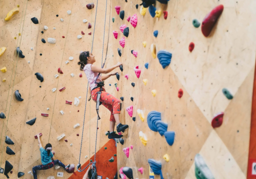

In [7]:
#open and to_thumb are part of https://docs.fast.ai/vision.core.html
from fastai.vision.all import *
Image.open('climbing.jpg').to_thumb(256,256)

In [8]:
image_search_dwnld('brick wall photos', 'brick.jpg')

Searching for 'brick wall photos'
Image downloaded successfully


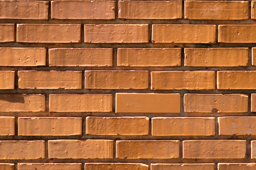

In [9]:
#download a motorbike image save as motorbike.jpg
Image.open('brick.jpg').to_thumb(256,256)

## 2. download images for training

In [10]:
#create a tuple for the positive and negative searches
searches = 'climbing wall','brick wall'
#create a new folder to store images using pathlib
path = Path('wall_classifier')

from time import sleep
#download 30 normal, sun and shade images for both forests and birds i.e. 90 images
#store images in two folders one for birds, one for forests
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    #sleep(10)  # Pause between searches to avoid over-loading server
    #download_images(dest, urls=search_images(f'{o} sun photo'))
   # sleep(10)
   # download_images(dest, urls=search_images(f'{o} shade photo'))
    #sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'climbing wall photo'
Searching for 'brick wall photo'


Remove any images that cant be opened

In [11]:
#Create list of images in that can’t be opened using fastai function verify_iamges
failed = verify_images(get_image_files(path))
#Remove files that did not download correctly i.e. apply Path.unlink to each bad file
# https://docs.python.org/3/library/pathlib.html
failed.map(Path.unlink)
len(failed)

3

## 3. Create data block and train

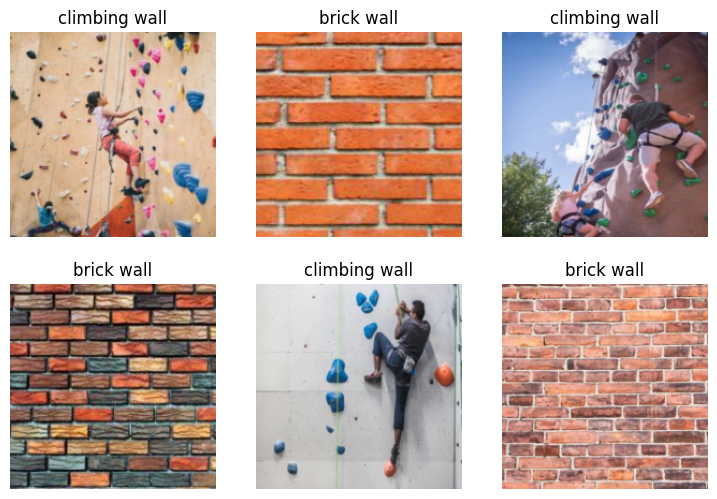

In [12]:
dls = DataBlock(
    # The inputs to our model are images, and the outputs are categories (e.g."bird" or "forest").
    blocks=(ImageBlock, CategoryBlock),
    # To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
    #path was set in the previous cell when checking for failed images
    get_items=get_image_files,
    #Split the data into training and validation sets randomly, using 20% of the data for the validation set.
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    #The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).
    get_y=parent_label,
    # Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).
    item_tfms=[RandomResizedCrop(192)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.726773,0.605577,0.222222,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.665024,0.397570,0.222222,00:08
1,0.583518,0.188185,0.222222,00:09
2,0.458907,0.038058,0.000000,00:08
3,0.350808,0.004780,0.000000,00:08
4,0.291956,0.000998,0.000000,00:10


## 4. Make prediction

In [16]:
#PILImage.create coverts an image to a tensor https://docs.fast.ai/vision.core.html
result,_,probs = learn.predict(PILImage.create('brick.jpg'))
print(f"This is a: {result}.")
#print(f"Probability it's a brick wall: {probs[0]:.4f}")

This is: brick wall.


In [15]:
probs

tensor([1.0116e-05, 9.9999e-01])

In [16]:
_

tensor(1)

## 5. Create pkl file

In [89]:
learn.export('climbing.pkl')

# Create code for the application file

In [18]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing i

In [19]:
#| export
import gradio as gr
from fastai.vision.all import *
import skimage

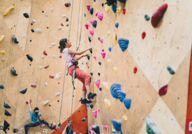

In [20]:
im = PILImage.create('climbing.jpg')
im.thumbnail((192,192))
im

In [21]:
#| export
learn = load_learner('climbing.pkl')

In [22]:
learn.predict(im)

('climbing wall', tensor(1), tensor([1.3150e-04, 9.9987e-01]))

In [34]:
#| export
categories = ('Brick wall', 'Climbing wall')

def classify_image(image):
    #img_resized = resize_image_pil(image, 224, 224)
    pred,idx,probs = learn.predict(image)
    return dict(zip(categories, map(float,probs)))

In [36]:
#| export
image = gr.Image()
label = gr.Label()
examples = ['climbing.jpg', 'brick.jpg']

intf = gr.Interface(fn=classify_image, inputs = image, outputs=label, examples = examples, allow_flagging="never")
intf.launch(inline=False)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://539f4e251f2a23c470.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [39]:
result_dict = classify_image('climbing.jpg')
result_dict

{'Brick wall': 2.9932998586446047e-05, 'Climbing wall': 0.9999700784683228}

In [40]:
!pip install nbdev

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [42]:
#the following copies all code with #|export to an app file - note that the first parameter must be the notebook name
import nbdev
nbdev.export.nb_export('app.ipynb', 'app')
print('Export successful')

Object `nbdev` not found.
